# 미니 프로젝트 : 시계열 분류 

###  library load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,average_precision_score

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

In [2]:
plt.rcParams["figure.figsize"] = (9, 5)

def mape(a, f): 
    a = pd.Series(a).astype(float)
    f = pd.Series(f).astype(float)
    return np.mean(np.abs((a - f)/a)) * 100

###  AirPassengers 로드 & 정리

In [3]:
ap = pd.read_csv("./data/AirPassengers.csv", parse_dates=["Month"], index_col="Month")
ap = ap.asfreq("MS")  
y = ap["#Passengers"].astype(float)

display(y)

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Name: #Passengers, Length: 144, dtype: float64

- 추세↑ + 계절성(12개월) + 변동성 증가(분산 비정상)

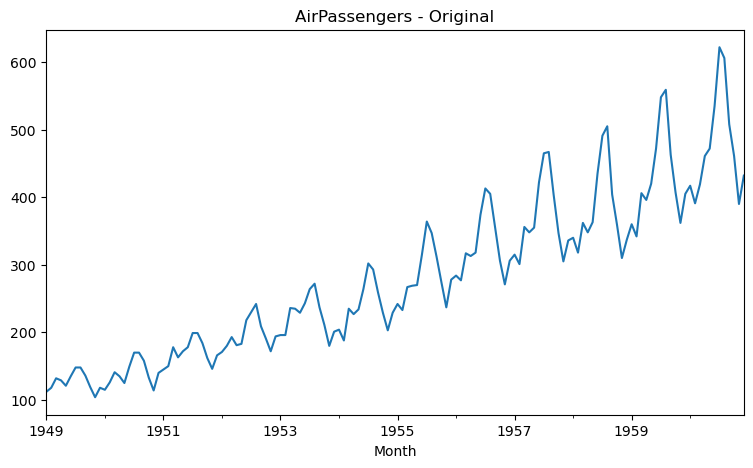

In [4]:
y.plot(title="AirPassengers - Original")
plt.show()

###  STL 분해
- Trend: 완만한 증가
- Seasonal: 12개월 주기 반복
- Residual: 패턴 없음 → 모델링 준비 OK

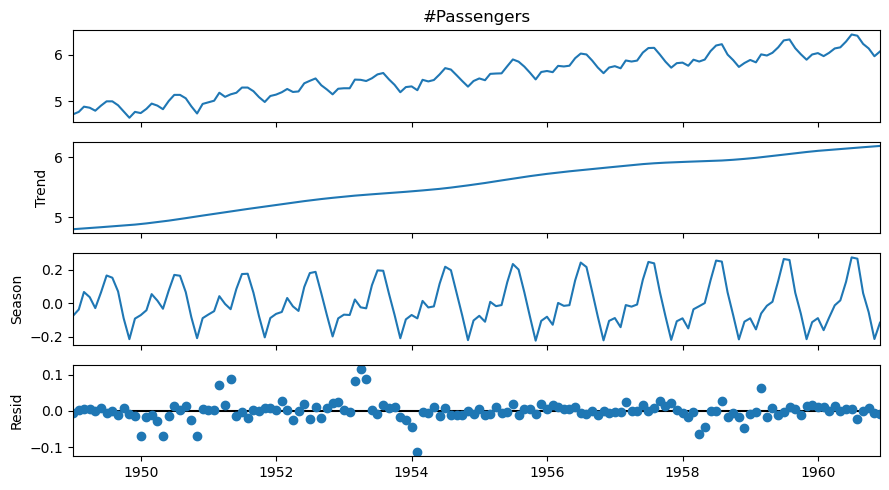

In [5]:
y_log = np.log(y)

stl = STL(y_log, period=12, robust=True)
res = stl.fit()
res.plot()
plt.show()

### 정상성 검사 (ADF/KPSS)
- 로그만 취한 시계열은 추세/계절성 때문에 비정상
- 1차 차분(d=1) + 12계절 차분(D=1) 후에는 ADF·KPSS가 모두 정상성을 지지

#### 차분 전전 정상성 검사
- ADF[log(y)] p = 0.4224 (> 0.05)   
  - ADF의 귀무가설(H0: 단위근 존재, 비정상성)을 기각 못함 → 비정상
- KPSS[log(y)] p = 0.01 (< 0.05)
  - KPSS의 귀무가설(H0: 정상성)을 기각 → 비정상

In [6]:
def adf_print(x, name="series"):
    stat, p, *_ = adfuller(x.dropna())
    print(f"ADF[{name}] p-value:", p)

def kpss_print(x, name="series"):
    stat, p, *_ = kpss(x.dropna(), regression="c", nlags="auto")
    print(f"KPSS[{name}] p-value:", p)

adf_print(y_log, "log(y)")
kpss_print(y_log, "log(y)")

ADF[log(y)] p-value: 0.42236677477038814
KPSS[log(y)] p-value: 0.01


C:\Users\Administrator\AppData\Local\Temp;\ipykernel_3136\3455055735.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, *_ = kpss(x.dropna(), regression="c", nlags="auto")


#### 차분 후 정상성 검사
- ADF[log(y) 1차 + 계절(12) 차분] p = 0.00025 (< 0.05)
  - 단위근 없음 → 정상성 달성
- KPSS[log(y) 1차 + 계절(12) 차분] p = 0.1 (≥ 0.1로 캡됨)
  - 정상성 귀무를 기각하지 못함 → 정상성에 문제 없음으로 해석

In [7]:
dy = y_log.diff().dropna()      
Ddy = dy.diff(12).dropna()          

adf_print(Ddy, "log(y) diff1 & seas12")
kpss_print(Ddy, "log(y) diff1 & seas12")

ADF[log(y) diff1 & seas12] p-value: 0.00024859123113839645
KPSS[log(y) diff1 & seas12] p-value: 0.1


C:\Users\Administrator\AppData\Local\Temp;\ipykernel_3136\3455055735.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, *_ = kpss(x.dropna(), regression="c", nlags="auto")


#### ACF/PACF
- ACF 12배수에서 유의 → 계절 MA( Q ) 후보
- PACF 12배수에서 유의 → 계절 AR( P ) 후보   
→ 작은 그리드로 SARIMA 탐색 필요

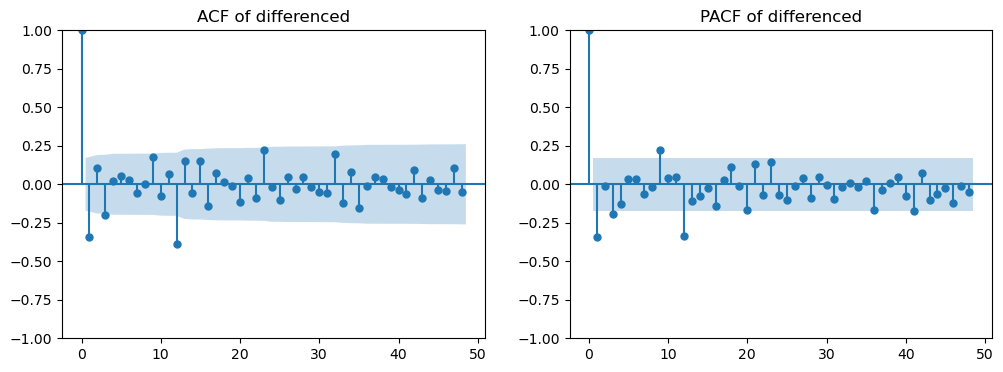

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

plot_acf(Ddy, lags=48, ax=ax[0])
ax[0].set_title("ACF of differenced")
plot_pacf(Ddy, lags=48, ax=ax[1])
ax[1].set_title("PACF of differenced")
plt.show()

---

### tsfresh 분류
#### 커스텀 분할

In [9]:
download_robot_execution_failures()
timeseries, y_bin = load_robot_execution_failures() 

def custom_classification_split(x, y, test_size=0.3, random_state=42):
    rng = np.random.RandomState(random_state)

    n_true = int(y.sum())
    n_false = len(y) - n_true
    n_true_test = int(n_true * test_size)
    n_false_test = int(n_false * test_size)

    true_ids = y[y==True].index.to_list()
    false_ids = y[y==False].index.to_list()
    id_true_test = rng.choice(true_ids, size=n_true_test, replace=False).tolist()
    id_false_test = rng.choice(false_ids, size=n_false_test, replace=False).tolist()

    id_list = id_false_test + id_true_test 

    X_train = x[~x['id'].isin(id_list)]
    X_test = x[x['id'].isin(id_list)]
    y_train = y.drop(id_list)
    y_test = y.loc[id_list].sort_index()

    return X_train, y_train, X_test, y_test

X_train_ts, y_train_ts, X_test_ts, y_test_ts = custom_classification_split(timeseries, y_bin, test_size=0.2)

#### 특성 추출 & impute

In [10]:
settings = EfficientFCParameters()

feats_tr = extract_features(X_train_ts, column_id="id", column_sort="time", 
                            default_fc_parameters=settings)

feats_te = extract_features(X_test_ts,  column_id="id", column_sort="time", 
                            default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 26/26 [00:05<00:00,  4.63it/s]


In [11]:
impute(feats_tr)  

,T_x__variance_larger_than_standard_deviation,T_x__has_duplicate_max,T_x__has_duplicate_min,T_x__has_duplicate,T_x__sum_values,T_x__abs_energy,T_x__mean_abs_change,T_x__mean_change,T_x__mean_second_derivative_central,T_x__median,...,F_z__fourier_entropy__bins_5,F_z__fourier_entropy__bins_10,F_z__fourier_entropy__bins_100,F_z__permutation_entropy__dimension_3__tau_1,F_z__permutation_entropy__dimension_4__tau_1,F_z__permutation_entropy__dimension_5__tau_1,F_z__permutation_entropy__dimension_6__tau_1,F_z__permutation_entropy__dimension_7__tau_1,F_z__query_similarity_count__query_None__threshold_0.0,F_z__mean_n_absolute_max__number_of_maxima_7
3,1.0,0.0,1.0,1.0,-60.0,344.0,3.214286,0.071429,-0.076923,-5.0,...,1.213008,1.667462,2.079442,1.671595,2.369382,2.397895,2.302585,2.197225,0.0,65.142857
4,1.0,1.0,0.0,1.0,-93.0,763.0,3.714286,-0.428571,-0.192308,-6.0,...,1.255482,1.732868,2.079442,1.591096,1.979205,2.271869,2.302585,2.197225,0.0,65.428571
5,1.0,0.0,0.0,1.0,-105.0,849.0,4.071429,-0.357143,0.000000,-8.0,...,0.974315,1.213008,2.079442,1.332245,1.979205,2.271869,2.302585,2.197225,0.0,64.714286
6,1.0,0.0,0.0,1.0,-152.0,1584.0,2.214286,0.214286,0.307692,-10.0,...,0.900256,1.073543,1.494175,1.671595,2.369382,2.397895,2.302585,2.197225,0.0,61.857143
7,1.0,0.0,1.0,1.0,-107.0,823.0,2.857143,0.285714,-0.115385,-7.0,...,1.494175,1.906155,2.079442,1.671595,2.253858,2.397895,2.302585,2.197225,0.0,63.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,0.0,0.0,1.0,5083.0,1825597.0,18.857143,15.285714,-0.538462,394.0,...,0.900256,0.900256,1.386294,0.898137,1.126929,1.366711,1.609438,1.831020,0.0,958.000000
85,1.0,0.0,0.0,1.0,-511.0,18023.0,2.785714,-1.214286,0.192308,-33.0,...,0.376770,0.735622,1.906155,1.265857,1.820076,1.972247,2.163956,2.197225,0.0,40.285714
86,1.0,0.0,0.0,1.0,-987.0,67981.0,3.928571,-3.500000,-0.153846,-65.0,...,0.376770,0.376770,1.073543,0.535961,0.566086,0.600166,0.639032,0.683739,0.0,255.857143
87,1.0,0.0,0.0,1.0,-1921.0,247081.0,6.642857,-0.357143,0.461538,-126.0,...,1.073543,1.073543,1.667462,0.898137,1.126929,1.366711,1.609438,1.831020,0.0,1085.714286


In [12]:
impute(feats_te)

,T_y__variance_larger_than_standard_deviation,T_y__has_duplicate_max,T_y__has_duplicate_min,T_y__has_duplicate,T_y__sum_values,T_y__abs_energy,T_y__mean_abs_change,T_y__mean_change,T_y__mean_second_derivative_central,T_y__median,...,T_x__fourier_entropy__bins_5,T_x__fourier_entropy__bins_10,T_x__fourier_entropy__bins_100,T_x__permutation_entropy__dimension_3__tau_1,T_x__permutation_entropy__dimension_4__tau_1,T_x__permutation_entropy__dimension_5__tau_1,T_x__permutation_entropy__dimension_6__tau_1,T_x__permutation_entropy__dimension_7__tau_1,T_x__query_similarity_count__query_None__threshold_0.0,T_x__mean_n_absolute_max__number_of_maxima_7
1,0.0,1.0,1.0,1.0,-10.0,10.0,0.571429,0.000000,-0.038462,-1.0,...,0.735622,1.213008,2.079442,0.535961,0.836988,1.159589,1.227529,1.303092,0.0,3.000000
2,1.0,0.0,0.0,1.0,-20.0,90.0,2.214286,-0.214286,-0.038462,-1.0,...,1.320888,1.494175,1.667462,1.778233,2.484907,2.397895,2.302585,2.197225,0.0,6.285714
16,1.0,1.0,1.0,1.0,-64.0,292.0,0.785714,-0.214286,-0.038462,-4.0,...,1.213008,1.559581,2.079442,1.631345,2.138333,2.397895,2.302585,2.197225,0.0,11.571429
18,1.0,0.0,1.0,1.0,-48.0,234.0,2.785714,-0.357143,0.153846,-4.0,...,1.073543,1.073543,1.732868,1.631345,1.979205,2.145842,2.302585,2.197225,0.0,13.000000
19,1.0,0.0,0.0,1.0,198.0,23070.0,16.285714,-8.142857,0.346154,1.0,...,0.735622,1.073543,1.667462,1.671595,2.138333,2.271869,2.302585,2.197225,0.0,44.857143
23,1.0,0.0,0.0,1.0,88.0,17592.0,21.071429,-8.357143,2.461538,-5.0,...,0.735622,1.073543,2.079442,1.671595,2.138333,2.271869,2.302585,2.197225,0.0,28.857143
29,1.0,0.0,0.0,1.0,-157.0,7325.0,9.357143,5.357143,-1.730769,-3.0,...,1.320888,1.494175,1.667462,1.524707,1.979205,2.145842,2.163956,2.197225,0.0,15.714286
31,1.0,0.0,0.0,1.0,8.0,256.0,3.500000,-0.500000,-0.307692,-1.0,...,1.213008,1.386294,2.079442,1.524707,2.094729,2.397895,2.302585,2.197225,0.0,16.285714
37,1.0,0.0,0.0,1.0,-1547.0,272643.0,41.428571,2.142857,5.730769,-60.0,...,0.735622,1.073543,2.079442,1.524707,2.253858,2.397895,2.302585,2.197225,0.0,186.285714
42,1.0,0.0,0.0,1.0,-247.0,15799.0,11.500000,5.071429,0.730769,-6.0,...,0.735622,0.735622,1.494175,1.418069,2.094729,2.271869,2.302585,2.197225,0.0,45.285714


#### y와 행 인덱스 맞춤

In [13]:
feats_tr = feats_tr.sort_index()
y_train_ts = y_train_ts.sort_index()
y_train_ts = y_train_ts.loc[feats_tr.index]

feats_te = feats_te.sort_index()
y_test_ts = y_test_ts.sort_index()
y_test_ts = y_test_ts.loc[feats_te.index]

#### 컬럼 정합성(훈련 기준으로 테스트를 맞춤)

In [14]:
# 1) 컬럼명을 문자열로 통일
feats_tr.columns = feats_tr.columns.map(str)
feats_te.columns = feats_te.columns.map(str)

# 2) 상수 컬럼 제거를 훈련 기준으로 결정
vt = VarianceThreshold(threshold=0.0)
vt.fit(feats_tr.fillna(0.0))
mask = vt.get_support()
feats_tr = feats_tr.loc[:, mask]

# 3) 테스트를 훈련 컬럼에 정확히 reindex
feats_te = feats_te.reindex(columns=feats_tr.columns, fill_value=0.0)
feats_te = feats_te[feats_tr.columns]

# 4) NaN 안전 처리
feats_tr = feats_tr.fillna(0.0)
feats_te = feats_te.fillna(0.0)

### 모델 학습 + 분류 리포트

In [15]:
y_train_ts = y_train_ts.astype(int)
y_test_ts  = y_test_ts.astype(int)

pos = int(y_train_ts.sum())
neg = int(len(y_train_ts) - pos)
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

In [16]:
logit = Pipeline([("scaler", StandardScaler()),
                  ("clf", LogisticRegression(C=1.0, max_iter=1000, solver="liblinear", 
                                             class_weight="balanced"))])

rf = RandomForestClassifier(n_estimators=500, max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1,
                            class_weight="balanced",    
                            n_jobs=-1, random_state=42)

xgb_clf = xgb.XGBClassifier(objective="binary:logistic", n_estimators=500, max_depth=5, 
                            learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
                            reg_lambda=1.0, scale_pos_weight=scale_pos_weight,
                            eval_metric="logloss", n_jobs=-1, random_state=42)

models = {"LogisticRegression": logit,
          "RandomForest": rf,
          "XGBoost": xgb_clf}

In [17]:
def eval_and_report(model, Xtr, ytr, Xte, yte, name):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(Xte)
        y_score = s
    else:
        y_score = y_pred.astype(float)

    print(f"\n=== {name} ===")
    print("Accuracy :", round(accuracy_score(yte, y_pred), 4))
    print("ROC-AUC  :", round(roc_auc_score(yte, y_score), 4))
    print("PR-AUC   :", round(average_precision_score(yte, y_score), 4))

    print("\nConfusion matrix")
    print(confusion_matrix(yte, y_pred))

    print("\nClassification report")
    print(classification_report(yte, y_pred, target_names=["false", "true"]))


for name, mdl in models.items():
    eval_and_report(mdl, feats_tr, y_train_ts, feats_te, y_test_ts, name)


=== LogisticRegression ===
Accuracy : 0.9412
ROC-AUC  : 1.0
PR-AUC   : 1.0

Confusion matrix
[[12  1]
 [ 0  4]]

Classification report
              precision    recall  f1-score   support

       false       1.00      0.92      0.96        13
        true       0.80      1.00      0.89         4

    accuracy                           0.94        17
   macro avg       0.90      0.96      0.92        17
weighted avg       0.95      0.94      0.94        17


=== RandomForest ===
Accuracy : 1.0
ROC-AUC  : 1.0
PR-AUC   : 1.0

Confusion matrix
[[13  0]
 [ 0  4]]

Classification report
              precision    recall  f1-score   support

       false       1.00      1.00      1.00        13
        true       1.00      1.00      1.00         4

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17


=== XGBoost ===
Accuracy : 1.0
ROC-AUC  : 1.0
PR-AUC   : 1.0

Confusion matrix
[[1